# Filter

## Imports

In [1]:
import numpy as np
import plotly.express as px
import plotly.io as pio
from PIL import Image as im

pio.templates.default = 'plotly_dark'

## Functions

In [159]:
def draw(image, mode='rgb'):
    if mode == 'gray':
        color_scale = ['#000000', '#FFFFFF']
        px.imshow(image, color_continuous_scale=color_scale).update_layout(height=800).show()
    elif mode == 'rgb':
        px.imshow(image).update_layout(height=950).show()

In [12]:
def pixelate(img, pixel_size):
    width, height = img.size
    num_blocks_x = width // pixel_size
    num_blocks_y = height // pixel_size

    img = img.resize((num_blocks_x, num_blocks_y), resample=im.NEAREST)
    img = img.resize((width, height), resample=im.NEAREST)

    return img

In [163]:
def sliding_function(mat, kernel):
    mat = np.array(mat)
    kernel_size = kernel.shape[1]
    l = kernel_size // 2
    r = kernel_size-l

    height, width = mat.shape
    
    for h in range(height)[l:-r]:
        for w in range(width)[l:-r]:
            mat[h, w] = np.sum(mat[h-l:h+r, w-l:w+r] * kernel)

    return mat

In [126]:
def crt_effect(mat,intensity=1):

    height, width = mat.shape
    for h in range(height)[:-intensity:intensity*2]:
        for sub_h in range(intensity):
            for w in range(width):
                    mat[h+sub_h, w] -= mat[h+sub_h, w]//3
    return mat

## Image Open

In [151]:
# img = im.open('yellow.jpg')
# img = im.open('white.jpg')
img = im.open('lambo.png')
hsv = img.convert('HSV')
gray = np.array(hsv.getchannel('V'))

# gray = np.array(img.convert('L'))

## Output

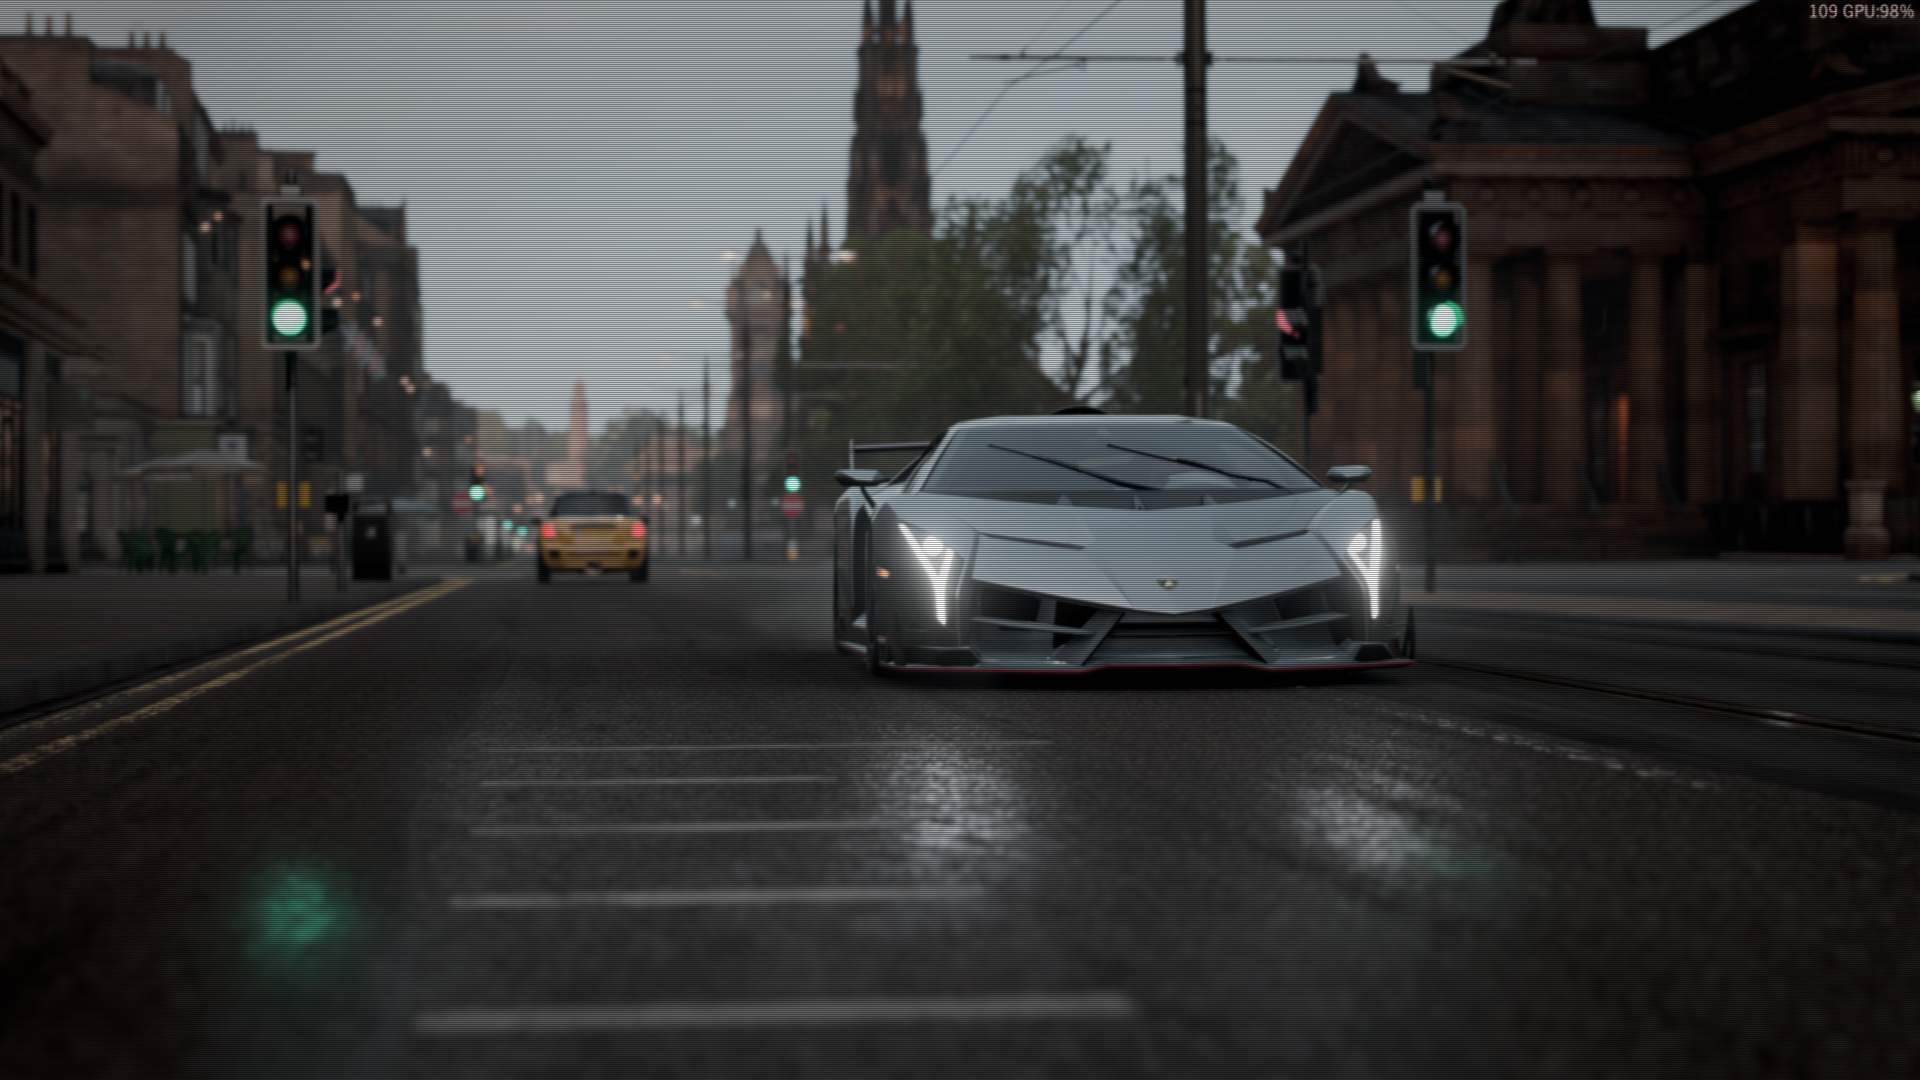

In [161]:
# kernel = np.array([[1,2,1], [2,-4,2], [1,2,1]])
# kernel = np.array([[1,2,1], [2,4,2], [1,2,1]])

kernel = np.ones((3, 3))/9
# kernel[1, 1] = .25

slide = sliding_function(gray, kernel)
crt = crt_effect(slide, intensity=1)

hsv_arr = np.array(hsv)

hsv_arr[:,:,0] = (hsv_arr[:,:,0] - 5) % 256
hsv_arr[:,:,1] = (hsv_arr[:,:,1] - hsv_arr[:,:,1] // 3) % 256
hsv_arr[:,:,2] = crt

result = im.fromarray(hsv_arr,'HSV').convert('RGB')

# draw(result,'rgb')
display(result)
# result.show()

In [162]:
result.save('LamboFiltered.png')